# 1D CNN with MFCC Mean

### Import libraries

In [22]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

### Data preparation

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


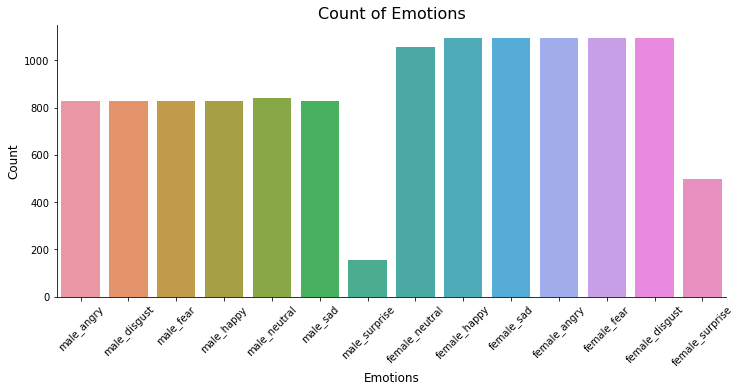

In [23]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("C:/Users/aksha/Downloads/College Project/Code/SpeechEmotionRecognitionwithCNN/Data_path.csv")
ref.head()

plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(ref.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [24]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[-11.113932, -7.2157545, -6.2191906, -5.926542..."
1,"[-24.44983, -22.465742, -22.928043, -23.243807..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458632, -22.467833, -25.884357, -27.82704..."


In [25]:
# save it
df.to_pickle('my4EmotionDatabases-mfccs')
# load it
df = pd.read_pickle('my4EmotionDatabases-mfccs')
df.head()

,feature
0,"[-11.113932, -7.2157545, -6.2191906, -5.926542..."
1,"[-24.44983, -22.465742, -22.928043, -23.243807..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458632, -22.467833, -25.884357, -27.82704..."


### Data processing

In [26]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-11.113932,-7.215755,-6.219191,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088851,-5.023864,-5.254714,-5.234093,-5.310308,-5.621667,-6.072197,-6.611348,-2.509089,1.964608
1,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-24.449829,-22.465742,-22.928043,-23.243807,-22.926605,-23.432241,-14.830002,...,-22.627258,-22.633406,-22.511599,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-24.530262,-25.457796
2,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-25.000114,-24.520256,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-1.529839,-4.333437,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-22.458632,-22.467833,-25.884357,-27.827045,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-25.902941,-25.589964


In [27]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-11.113932,-7.215755,-6.219191,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088851,-5.023864,-5.254714,-5.234093,-5.310308,-5.621667,-6.072197,-6.611348,-2.509089,1.964608
1,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-24.449829,-22.465742,-22.928043,-23.243807,-22.926605,-23.432241,-14.830002,...,-22.627258,-22.633406,-22.511599,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-24.530262,-25.457796
2,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-25.000114,-24.520256,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-1.529839,-4.333437,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-22.458632,-22.467833,-25.884357,-27.827045,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-25.902941,-25.589964


### Splitting the Dataset into Training and Test

In [28]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-18.611181,-17.616537,-18.411484,-18.987421,-17.404621,-16.747272,-17.733747,-18.055027,-17.931210,-15.913172,...,-22.899403,-21.647814,-19.758650,-18.879402,-19.397379,-20.171659,-22.689241,-24.612816,-24.153774,-22.703133
3860,-10.786573,-14.882178,-23.087044,-22.467028,-20.362326,-19.076141,-19.761507,-13.231027,-11.808992,-16.756001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-1.533947,-4.030604,-9.614023,-12.045171,-9.992991,-11.926252,-14.008465,-13.561554,-14.024567,-15.151947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-4.531077,-3.933793,-4.567834,-5.871509,-5.282474,-6.490459,-8.156467,-9.188803,-8.681726,-8.212409,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-20.621704,-21.587505,-20.563650,-20.703461,-21.205715,-18.608528,-18.446669,-16.211843,-14.257653,-15.160404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-17.514992,-18.551868,-17.043013,-16.977903,-19.369631,-19.562126,-22.008749,-20.178379,-17.989597,-19.336285,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-18.740366,-18.824934,-16.149492,-16.963453,-18.229979,-18.183958,-19.274342,-18.395124,-16.951290,-16.672031,...,-17.882132,-19.390713,-17.779474,-19.165974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-19.066853,-18.328382,-17.710285,-18.043194,-18.252481,-18.710627,-16.626354,-17.831005,-18.028345,-17.859104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-20.760592,-20.047138,-18.961348,-19.468687,-19.316292,-18.162565,-18.102333,-19.914131,-20.931385,-19.215496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-18.252928,-17.727369,-19.222477,-18.469973,-17.572329,-17.850538,-17.932026,-20.588900,-18.612185,-15.990727,...,-18.065437,-18.135092,-19.665306,-20.741905,-20.273033,-18.371035,-15.576723,-17.512487,-17.008547,-18.195280


### Data Normalization 

In [29]:
# Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.185662,0.302468,0.437165,0.387895,0.498989,0.543636,0.462580,0.433146,0.435814,0.580897,...,-0.883216,-0.815256,-0.695046,-0.633007,-0.679832,-0.722842,-0.865393,-0.989019,-0.972385,-0.882535
3860,0.732048,0.501149,0.089951,0.130028,0.280118,0.371251,0.312744,0.788958,0.886902,0.518818,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
9761,1.378151,1.289636,1.090478,0.902371,1.047452,0.900492,0.737849,0.764579,0.723657,0.636966,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
7620,1.168864,1.296670,1.465215,1.359888,1.396032,1.302854,1.170266,1.087108,1.117320,1.148100,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
11586,0.045269,0.013933,0.277342,0.260723,0.217707,0.405864,0.409900,0.569097,0.706483,0.636343,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
7914,0.262208,0.234506,0.538790,0.536816,0.353578,0.335278,0.146691,0.276530,0.431512,0.328767,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
9513,0.176641,0.214664,0.605144,0.537887,0.437912,0.437291,0.348742,0.408061,0.508015,0.525003,...,-0.571347,-0.675378,-0.572761,-0.650610,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
5835,0.153843,0.250744,0.489237,0.457870,0.436247,0.398307,0.544407,0.449669,0.428657,0.437569,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
5389,0.035570,0.125858,0.396331,0.352229,0.357525,0.438875,0.435344,0.296021,0.214760,0.337663,...,0.540193,0.526315,0.525757,0.526696,0.511816,0.512069,0.512981,0.501471,0.496906,0.492873
11222,0.210678,0.294414,0.376940,0.426242,0.486579,0.461972,0.447929,0.246251,0.385639,0.575185,...,-0.582741,-0.597564,-0.689279,-0.747415,-0.733626,-0.612608,-0.433306,-0.559041,-0.537736,-0.609439


In [30]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [10]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

### 1D CNN Modelling

In [11]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

C:\Users\aksha\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Description of 1D CNN-Model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 63s 108ms/step - loss: 2.4290 - accuracy: 0.1922 - val_loss: 2.4509 - val_accuracy: 0.2489
Epoch 2/100
571/571 [==============================] - 63s 110ms/step - loss: 2.2009 - accuracy: 0.2632 - val_loss: 2.2444 - val_accuracy: 0.2812
Epoch 3/100
571/571 [==============================] - 62s 109ms/step - loss: 2.0879 - accuracy: 0.2847 - val_loss: 2.1510 - val_accuracy: 0.2979
Epoch 4/100
571/571 [==============================] - 63s 110ms/step - loss: 2.0104 - accuracy: 0.3137 - val_loss: 2.0925 - val_accuracy: 0.3223
Epoch 5/100
571/571 [==============================] - 64s 111ms/step - loss: 1.9546 - accuracy: 0.3253 - val_loss: 2.0386 - val_accuracy: 0.3443
Epoch 6/100
571/571 [==============================] - 64s 111ms/step - loss: 1.9080 - accuracy: 0.3494 - val_loss: 2.0173 - val_accuracy: 0.3403
Epoch 7/100
571/571 [==============================] - 63s 111ms/step - loss: 1.8679 - accuracy: 0.3619 - val_loss: 1.9612 -

Epoch 57/100
571/571 [==============================] - 60s 106ms/step - loss: 1.2321 - accuracy: 0.5786 - val_loss: 1.6180 - val_accuracy: 0.4357
Epoch 58/100
571/571 [==============================] - 60s 106ms/step - loss: 1.2326 - accuracy: 0.5857 - val_loss: 1.5848 - val_accuracy: 0.4485
Epoch 59/100
571/571 [==============================] - 60s 106ms/step - loss: 1.2214 - accuracy: 0.5851 - val_loss: 1.5963 - val_accuracy: 0.4413
Epoch 60/100
571/571 [==============================] - 61s 106ms/step - loss: 1.2139 - accuracy: 0.5877 - val_loss: 1.5961 - val_accuracy: 0.4446
Epoch 61/100
571/571 [==============================] - 60s 106ms/step - loss: 1.2060 - accuracy: 0.5891 - val_loss: 1.6058 - val_accuracy: 0.4308
Epoch 62/100
571/571 [==============================] - 60s 105ms/step - loss: 1.1990 - accuracy: 0.5893 - val_loss: 1.5819 - val_accuracy: 0.4512
Epoch 63/100
571/571 [==============================] - 60s 106ms/step - loss: 1.1867 - accuracy: 0.5968 - val_loss: 1

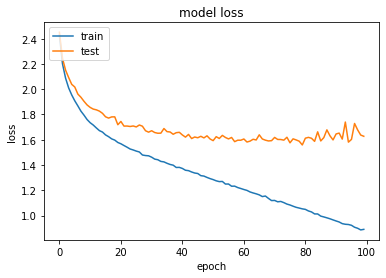

In [13]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model serialisation

In [14]:
# Save model and weights
model_name = 'Emotion_Model_1D_MFCC.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_1D_MFCC.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_1D_MFCC.h5 


### Model validation

In [15]:
# loading json and model architecture 
json_file = open('model_json_1D_MFCC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_1D_MFCC.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 43.37%


In [16]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 3s 16ms/step


array([2, 3, 8, ..., 0, 5, 3], dtype=int64)

In [17]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_happy
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_happy
176,male_neutral,male_neutral
177,female_fear,female_happy
178,female_happy,female_fear
179,female_neutral,female_sad


In [18]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_1D_MFCC.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,272
female_disgust,311
female_fear,355
female_happy,614
female_neutral,228
female_sad,310
female_surprise,126
male_angry,180
male_disgust,82


# Emotion vs Gender Accuracy of 1D CNN model with MFCC

In [19]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

# Emotion by gender accuracy of 1D CNN model with MFCC

0.4822407366805525


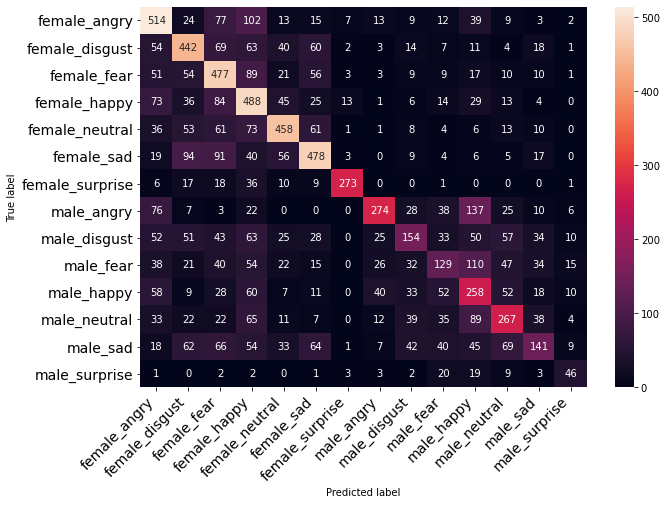

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.50      0.61      0.55       839
 female_disgust       0.50      0.56      0.53       788
    female_fear       0.44      0.59      0.50       810
   female_happy       0.40      0.59      0.48       831
 female_neutral       0.62      0.58      0.60       785
     female_sad       0.58      0.58      0.58       822
female_surprise       0.89      0.74      0.81       371
     male_angry       0.67      0.44      0.53       626
   male_disgust       0.40      0.25      0.30       625
      male_fear       0.32      0.22      0.26       583
     male_happy       0.32      0.41      0.36       636
   male_neutral       0.46      0.41      0.44       644
       male_sad       0.41      0.22      0.28       651
  male_surprise       0.44      0.41      0.43       111

       accuracy                           0.48      9122
      macro avg       0.50      0.47      0.47      9122
   weighted avg       0.49   

# Gender Accuracy Result of 1D CNN model with MFCC

0.829423372067529


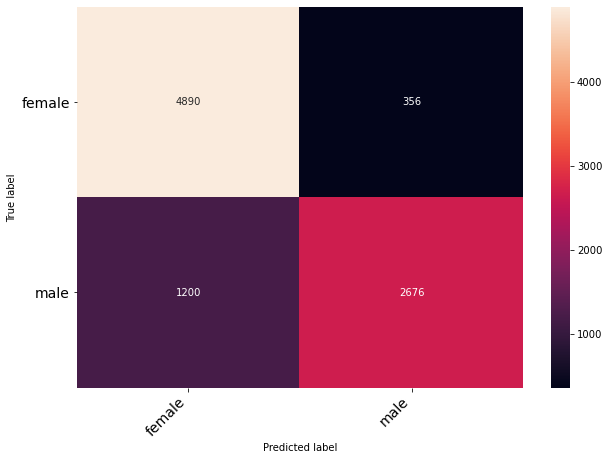

In [22]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.80      0.93      0.86      5246
        male       0.88      0.69      0.77      3876

    accuracy                           0.83      9122
   macro avg       0.84      0.81      0.82      9122
weighted avg       0.84      0.83      0.83      9122



# Emotion Accuracy of 1D CNN model with MFCC

0.526200394650296


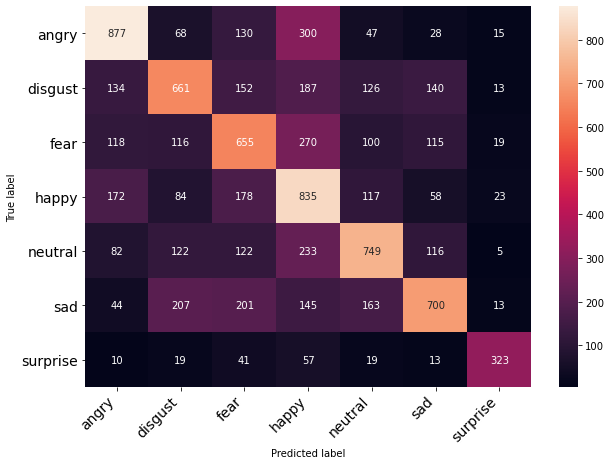

In [24]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122



# Live Demo of 1D CNN model with MFCC

In [4]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "C:/Users/aksha/Downloads/College Project/Data Set/Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
data, sampling_rate = librosa.load(path)

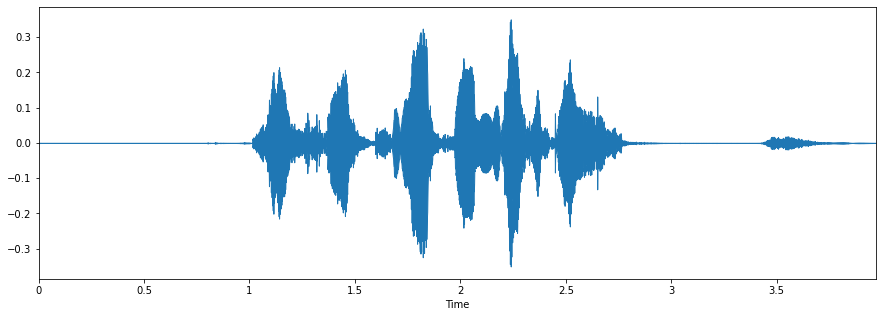

In [5]:
# % pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [6]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [7]:
livedf2= pd.DataFrame(data=livedf2)

In [8]:
livedf2 = livedf2.stack().to_frame().T

In [9]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-47.877094,-47.763382,-47.888924,-46.265957,-45.836617,-44.39769,-44.516685,-45.67358,-44.966022,-46.907654,...,-36.015137,-34.573044,-35.278614,-37.256733,-38.41914,-39.290897,-39.117245,-40.683201,-43.706734,-44.985847


In [10]:
twodim= np.expand_dims(livedf2, axis=2)

In [12]:
# loading json and model architecture 
json_file = open('model_json_1D_MFCC.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_1D_MFCC.h5")
print("Loaded model from disk")

livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

Loaded model from disk
1/1 [==============================] - 0s 287ms/step


In [13]:
livepreds

array([[5.6927304e-19, 4.5745954e-15, 4.5333213e-22, 7.3950351e-13,
        2.0800226e-08, 2.3582197e-12, 6.1868748e-05, 3.9457066e-19,
        9.9496114e-01, 3.3146253e-07, 2.4736834e-13, 2.0981098e-03,
        2.8761132e-03, 2.3639370e-06]], dtype=float32)

In [17]:
livepreds.shape

(1, 14)

In [18]:
livepreds1=livepreds.argmax(axis=1)

In [19]:
liveabc = livepreds1.astype(int).flatten()

In [31]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_disgust'], dtype=object)